In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, homogeneity_score, completeness_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tabulate import tabulate
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [4]:
data = pd.read_csv("C:\\Users\\SHREEMATHI\\Downloads\\archive (37)\\Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data = data.drop('CustomerID', axis=1)
data_encoded = pd.get_dummies(data, columns=['Gender'])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)

### (a)Principal Component Analysis

In [6]:
pca = PCA()
pca.fit(data_scaled)

PCA()

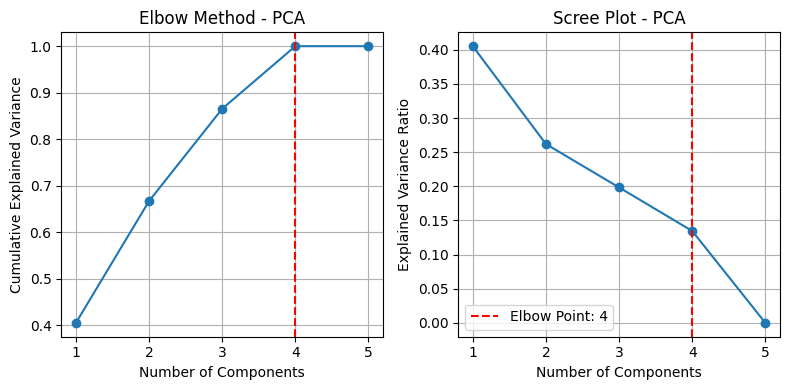

Number of Components based on Kaiser's criterion: 2
Number of Components based on Elbow Method: 4
Number of Components based on Scree Plot: 5


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance')
ax1.set_title('Elbow Method - PCA')
ax1.grid(True)
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
elbow_point = np.argmax(explained_variance_ratio_cumsum > 0.95) + 1
ax1.axvline(elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
ax2.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('Scree Plot - PCA')
ax2.grid(True)
ax2.axvline(elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.legend()
plt.tight_layout()
plt.show()
eigenvalues = pca.explained_variance_
kaiser_threshold = 1
num_components_kaiser = np.sum(eigenvalues > kaiser_threshold)
print("Number of Components based on Kaiser's criterion:", num_components_kaiser)
print("Number of Components based on Elbow Method:", elbow_point)
print("Number of Components based on Scree Plot:", len(pca.explained_variance_ratio_))

In [8]:
#Using built-in functions

pca_eval_metrics_builtin = []
for n in range(2, 6):
    pca = PCA(n_components=n)
    pca_result = pca.fit_transform(data_scaled)
    silhouette = silhouette_score(pca_result, data['Gender'])
    calinski_harabasz = calinski_harabasz_score(pca_result, data['Gender'])
    davies_bouldin = davies_bouldin_score(pca_result, data['Gender'])
    homogeneity = homogeneity_score(data['Gender'], data['Gender'])
    completeness = completeness_score(data['Gender'], data['Gender'])
    pca_eval_metrics_builtin.append((n, silhouette, calinski_harabasz, davies_bouldin, homogeneity, completeness))
headers = ["Components", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "Homogeneity", "Completeness"]
print("PCA Evaluation Metrics (Built-in Functions):")
print(tabulate(pca_eval_metrics_builtin, headers=headers, floatfmt=".4f", tablefmt="fancy_grid"))

PCA Evaluation Metrics (Built-in Functions):
╒══════════════╤══════════════╤═════════════════════╤══════════════════╤═══════════════╤════════════════╕
│   Components │   Silhouette │   Calinski-Harabasz │   Davies-Bouldin │   Homogeneity │   Completeness │
╞══════════════╪══════════════╪═════════════════════╪══════════════════╪═══════════════╪════════════════╡
│            2 │       0.5918 │            298.9244 │           0.7249 │        1.0000 │         1.0000 │
├──────────────┼──────────────┼─────────────────────┼──────────────────┼───────────────┼────────────────┤
│            3 │       0.4607 │            171.7889 │           0.9728 │        1.0000 │         1.0000 │
├──────────────┼──────────────┼─────────────────────┼──────────────────┼───────────────┼────────────────┤
│            4 │       0.3964 │            133.1329 │           1.1425 │        1.0000 │         1.0000 │
├──────────────┼──────────────┼─────────────────────┼──────────────────┼───────────────┼────────────────┤
│

In [9]:
# from scratch

cov_matrix = np.cov(data_scaled.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
num_components_kaiser = np.sum(sorted_eigenvalues > 1)
pca_eval_metrics_scratch = []
labels = np.arange(len(data_scaled)) % 2  
for n in range(2, 6):
    selected_eigenvectors = sorted_eigenvectors[:, :n]
    pca_result = np.dot(data_scaled, selected_eigenvectors)
    silhouette = silhouette_score(pca_result, labels)
    calinski_harabasz = calinski_harabasz_score(pca_result, labels)
    davies_bouldin = davies_bouldin_score(pca_result, labels)
    homogeneity = homogeneity_score(data['Gender'], labels)
    completeness = completeness_score(data['Gender'], labels)
    pca_eval_metrics_scratch.append((n, silhouette, calinski_harabasz, davies_bouldin, homogeneity, completeness))
headers = ["Components", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "Homogeneity", "Completeness"]
print("\nPCA Evaluation Metrics (From Scratch):")
print(tabulate(pca_eval_metrics_scratch, headers=headers, floatfmt=".4f", tablefmt="fancy_grid"))



PCA Evaluation Metrics (From Scratch):
╒══════════════╤══════════════╤═════════════════════╤══════════════════╤═══════════════╤════════════════╕
│   Components │   Silhouette │   Calinski-Harabasz │   Davies-Bouldin │   Homogeneity │   Completeness │
╞══════════════╪══════════════╪═════════════════════╪══════════════════╪═══════════════╪════════════════╡
│            2 │       0.1946 │             45.2940 │           2.0513 │        0.0003 │         0.0003 │
├──────────────┼──────────────┼─────────────────────┼──────────────────┼───────────────┼────────────────┤
│            3 │       0.1349 │             33.4414 │           2.3810 │        0.0003 │         0.0003 │
├──────────────┼──────────────┼─────────────────────┼──────────────────┼───────────────┼────────────────┤
│            4 │       0.1257 │             31.1502 │           2.4746 │        0.0003 │         0.0003 │
├──────────────┼──────────────┼─────────────────────┼──────────────────┼───────────────┼────────────────┤
│     

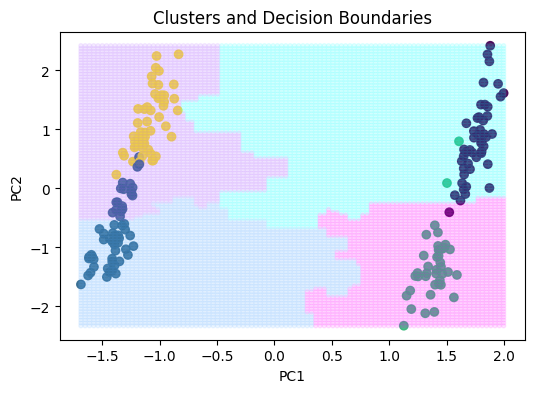

In [10]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(data_scaled)
hierarchical = AgglomerativeClustering(n_clusters=4)
cluster_labels = hierarchical.fit_predict(pca_result)
pc1_range = np.linspace(min(pca_result[:, 0]), max(pca_result[:, 0]), 100)
pc2_range = np.linspace(min(pca_result[:, 1]), max(pca_result[:, 1]), 100)
pc1_mesh, pc2_mesh = np.meshgrid(pc1_range, pc2_range)
mesh_points = np.c_[pc1_mesh.ravel(), pc2_mesh.ravel()]
mesh_labels = hierarchical.fit_predict(mesh_points)
plt.figure(figsize=(6, 4))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.9)
plt.scatter(mesh_points[:, 0], mesh_points[:, 1], c=mesh_labels, marker='.', cmap='cool', alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters and Decision Boundaries')
plt.show()

### (b)K Means Clustering

In [11]:
kmeans_scores = []
k_range = range(1, 11)

C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

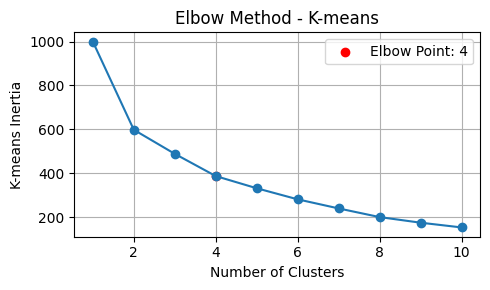

Number of Components based on Scree Plot: 4


In [12]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    kmeans_scores.append(kmeans.inertia_)
plt.figure(figsize=(5, 3))
plt.plot(list(k_range), kmeans_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('K-means Inertia')
plt.title('Elbow Method - K-means')
plt.grid(True)
elbow_index = 4
plt.scatter(elbow_index, kmeans_scores[elbow_index-1], color='red', marker='o', label=f'Elbow Point: {elbow_index}')
plt.legend()
plt.tight_layout()
plt.show()
print("Number of Components based on Scree Plot:", elbow_index)

In [13]:
#Using built-in functions

k = elbow_index
kmeans = KMeans(n_clusters=k)
kmeans.fit(data_scaled)
silhouette = silhouette_score(data_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(data_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(data_scaled, kmeans.labels_)
homogeneity = homogeneity_score(data['Gender'], kmeans.labels_)
completeness = completeness_score(data['Gender'], kmeans.labels_)
metrics_table = [
    ['Silhouette Score', silhouette],
    ['Calinski-Harabasz Score', calinski_harabasz],
    ['Davies-Bouldin Score', davies_bouldin],
    ['Homogeneity Score', homogeneity],
    ['Completeness Score', completeness]
]
print("K-means Evaluation Metrics:")
print(tabulate(metrics_table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

K-means Evaluation Metrics:
╒═════════════════════════╤════════════╕
│ Metric                  │      Score │
╞═════════════════════════╪════════════╡
│ Silhouette Score        │   0.332696 │
├─────────────────────────┼────────────┤
│ Calinski-Harabasz Score │ 103.611    │
├─────────────────────────┼────────────┤
│ Davies-Bouldin Score    │   1.2515   │
├─────────────────────────┼────────────┤
│ Homogeneity Score       │   1        │
├─────────────────────────┼────────────┤
│ Completeness Score      │   0.498073 │
╘═════════════════════════╧════════════╛


C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
#From scratch

class KMeans:
    def __init__(self, n_clusters, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for _ in range(self.max_iter):
            distances = self.compute_distances(X)
            labels = np.argmin(distances, axis=1)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
        self.labels_ = labels  
    def compute_distances(self, X):
        return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
kmeans_eval_metrics_scratch = []
n_clusters = elbow_index  
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data_scaled)
silhouette = silhouette_score(data_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(data_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(data_scaled, kmeans.labels_)
homogeneity = homogeneity_score(data['Gender'], kmeans.labels_)
completeness = completeness_score(data['Gender'], kmeans.labels_)
kmeans_eval_metrics_scratch.append((n_clusters, silhouette, calinski_harabasz, davies_bouldin, homogeneity, completeness))
headers = ["Clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "Homogeneity", "Completeness"]
print("K-means Clustering Evaluation Metrics (From Scratch):")
print(tabulate(kmeans_eval_metrics_scratch, headers=headers, floatfmt=".4f", tablefmt="fancy_grid"))

K-means Clustering Evaluation Metrics (From Scratch):
╒════════════╤══════════════╤═════════════════════╤══════════════════╤═══════════════╤════════════════╕
│   Clusters │   Silhouette │   Calinski-Harabasz │   Davies-Bouldin │   Homogeneity │   Completeness │
╞════════════╪══════════════╪═════════════════════╪══════════════════╪═══════════════╪════════════════╡
│          4 │       0.3291 │            102.7406 │           1.2604 │        1.0000 │         0.4975 │
╘════════════╧══════════════╧═════════════════════╧══════════════════╧═══════════════╧════════════════╛


C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


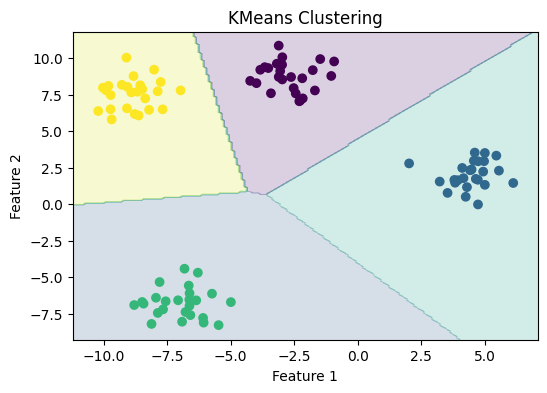

In [15]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=4, n_features=2, random_state=42)
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering')
plt.show()


### (c) Hierachical Clustering

In [16]:
hierarchical_scores = []
h_range = range(2, 10)

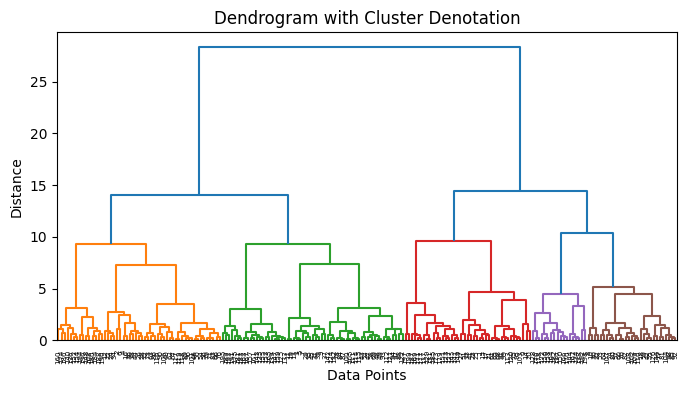

Number of clusters: 5


In [17]:
hierarchical = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical.fit(data_scaled)
linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(8, 4))
dendrogram(linkage_matrix, color_threshold=10) 
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram with Cluster Denotation')
plt.show()
distance_threshold = 10
clusters = fcluster(linkage_matrix, distance_threshold, criterion='distance')
num_clusters = len(set(clusters))
print("Number of clusters:", num_clusters)

In [18]:
#Using built-in functions

elbow_index = num_clusters
hierarchical = AgglomerativeClustering(n_clusters=elbow_index)
hierarchical.fit(data_scaled)
silhouette = silhouette_score(data_scaled, hierarchical.labels_)
calinski_harabasz = calinski_harabasz_score(data_scaled, hierarchical.labels_)
davies_bouldin = davies_bouldin_score(data_scaled, hierarchical.labels_)
homogeneity = homogeneity_score(data['Gender'], hierarchical.labels_)
completeness = completeness_score(data['Gender'], hierarchical.labels_)
metric_names = ['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score', 'Homogeneity Score', 'Completeness Score']
metric_values = [silhouette, calinski_harabasz, davies_bouldin, homogeneity, completeness]
table_data = [[metric_names[i], metric_values[i]] for i in range(len(metric_names))]
print("Hierarchical Clustering Evaluation Metrics:")
print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt="fancy_grid"))

Hierarchical Clustering Evaluation Metrics:
╒═════════════════════════╤═══════════╕
│ Metric                  │     Value │
╞═════════════════════════╪═══════════╡
│ Silhouette Score        │  0.333392 │
├─────────────────────────┼───────────┤
│ Calinski-Harabasz Score │ 94.0132   │
├─────────────────────────┼───────────┤
│ Davies-Bouldin Score    │  1.10962  │
├─────────────────────────┼───────────┤
│ Homogeneity Score       │  1        │
├─────────────────────────┼───────────┤
│ Completeness Score      │  0.447255 │
╘═════════════════════════╧═══════════╛


In [19]:
#from scratch

class HierarchicalClustering:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.labels = None
    def fit(self, X):
        n_samples = X.shape[0]
        distances = self.compute_distances(X)
        clusters = [[i] for i in range(n_samples)]
        while len(clusters) > self.n_clusters:
            min_distance = np.inf
            merge_indices = ()
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = self.cluster_distance(clusters[i], clusters[j], distances)
                    if dist < min_distance:
                        min_distance = dist
                        merge_indices = (i, j)
            clusters = self.merge_clusters(clusters, merge_indices)
        self.labels = self.assign_labels(clusters, n_samples)
    def compute_distances(self, X):
        return np.linalg.norm(X[:, np.newaxis] - X[np.newaxis, :], axis=2)
    def cluster_distance(self, cluster1, cluster2, distances):
        dists = distances[np.ix_(cluster1, cluster2)]
        return np.min(dists)
    def merge_clusters(self, clusters, merge_indices):
        i, j = merge_indices
        merged_cluster = clusters[i] + clusters[j]
        new_clusters = [c for idx, c in enumerate(clusters) if idx != i and idx != j]
        new_clusters.append(merged_cluster)
        return new_clusters
    def assign_labels(self, clusters, n_samples):
        labels = np.zeros(n_samples, dtype=int)
        for idx, cluster in enumerate(clusters):
            labels[cluster] = idx
        return labels
hierarchical_eval_metrics_scratch = []
hierarchical = HierarchicalClustering(n_clusters=n)
hierarchical.fit(data_scaled)
silhouette = silhouette_score(data_scaled, hierarchical.labels)
calinski_harabasz = calinski_harabasz_score(data_scaled, hierarchical.labels)
davies_bouldin = davies_bouldin_score(data_scaled, hierarchical.labels)
homogeneity = homogeneity_score(data['Gender'], hierarchical.labels)
completeness = completeness_score(data['Gender'], hierarchical.labels)
hierarchical_eval_metrics_scratch.append((n, silhouette, calinski_harabasz, davies_bouldin, homogeneity, completeness))
headers = ["Components", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "Homogeneity", "Completeness"]
print("\nHierarchical Clustering Evaluation Metrics (From Scratch):")
print(tabulate(hierarchical_eval_metrics_scratch, headers=headers, floatfmt=".4f", tablefmt="fancy_grid"))


Hierarchical Clustering Evaluation Metrics (From Scratch):
╒══════════════╤══════════════╤═════════════════════╤══════════════════╤═══════════════╤════════════════╕
│   Components │   Silhouette │   Calinski-Harabasz │   Davies-Bouldin │   Homogeneity │   Completeness │
╞══════════════╪══════════════╪═════════════════════╪══════════════════╪═══════════════╪════════════════╡
│            5 │       0.1645 │             39.0502 │           0.8506 │        1.0000 │         0.8335 │
╘══════════════╧══════════════╧═════════════════════╧══════════════════╧═══════════════╧════════════════╛


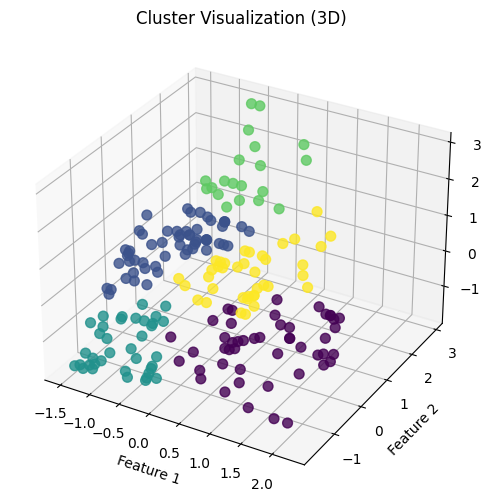

In [21]:
# Replace these with actual indices
feature1_index = 0
feature2_index = 1

selected_features = data_scaled[:, [feature1_index, feature2_index]]
num_clusters = 5
agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
cluster_labels = agglomerative.fit_predict(selected_features)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
marker_size = 50
alpha = 0.8
ax.scatter(selected_features[:, 0], selected_features[:, 1], data_scaled[:, 1], c=cluster_labels, cmap='viridis',
           s=marker_size, alpha=alpha)
ax.set_xlabel(f'Feature {feature1_index+1}')
ax.set_ylabel(f'Feature {feature2_index+1}')
ax.set_zlabel('Feature 3')
ax.set_title('Cluster Visualization (3D)')
plt.show()


C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


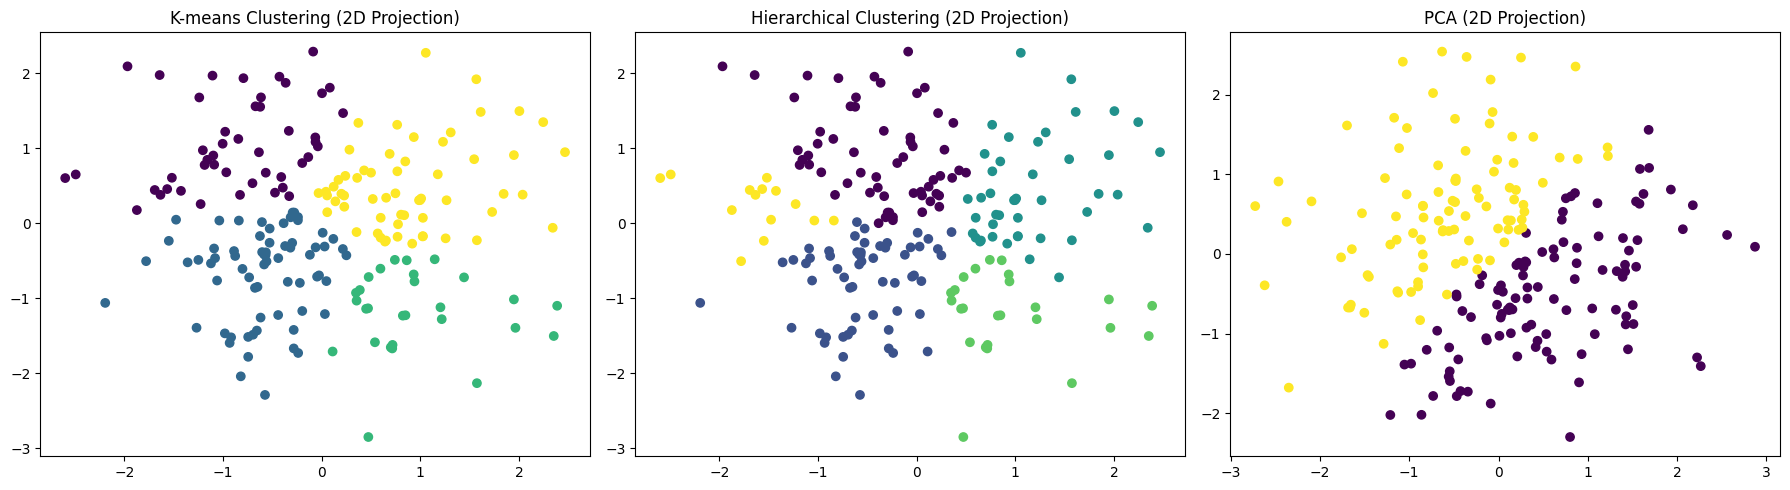

In [22]:
np.random.seed(0)
n_samples = 200
data = np.random.randn(n_samples, 2)
data_scaled = (data - data.mean(axis=0)) / data.std(axis=0)
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(data_scaled)
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(data_scaled)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)
hierarchical_silhouette = silhouette_score(data_scaled, hierarchical_labels)
pca_silhouette = silhouette_score(data_scaled, pca_data.argmax(axis=1))
kmeans_calinski_harabasz = calinski_harabasz_score(data_scaled, kmeans_labels)
hierarchical_calinski_harabasz = calinski_harabasz_score(data_scaled, hierarchical_labels)
pca_calinski_harabasz = calinski_harabasz_score(data_scaled, pca_data.argmax(axis=1))  # Use argmax to convert 2D array to 1D
kmeans_davies_bouldin = davies_bouldin_score(data_scaled, kmeans_labels)
hierarchical_davies_bouldin = davies_bouldin_score(data_scaled, hierarchical_labels)
pca_davies_bouldin = davies_bouldin_score(data_scaled, pca_data.argmax(axis=1))  # Use argmax to convert 2D array to 1D
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
def plot_2d_projection(ax, data, labels, title):
    ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    ax.set_title(title)
plot_2d_projection(axs[0], data_scaled, kmeans_labels, "K-means Clustering (2D Projection)")
plot_2d_projection(axs[1], data_scaled, hierarchical_labels, "Hierarchical Clustering (2D Projection)")
plot_2d_projection(axs[2], pca_data, pca_data.argmax(axis=1), "PCA (2D Projection)")
plt.tight_layout()
plt.show()

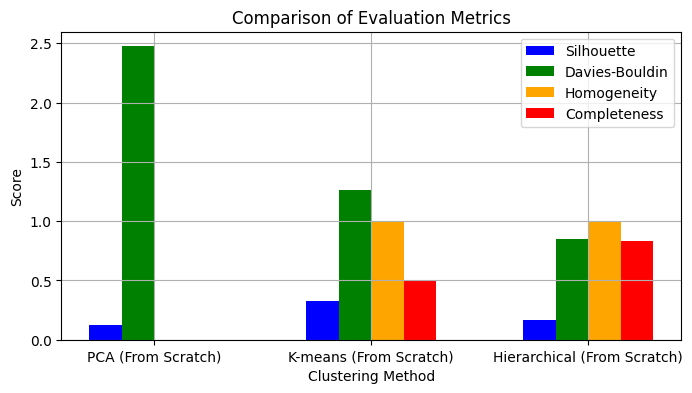

In [23]:
eval_metrics = {
    'PCA (From Scratch)': pca_eval_metrics_scratch,
    'K-means (From Scratch)': kmeans_eval_metrics_scratch,
    'Hierarchical (From Scratch)': hierarchical_eval_metrics_scratch
}
metric_names = ['Silhouette', 'Davies-Bouldin', 'Homogeneity', 'Completeness']
pca_components = 4
kmeans_components = 4
hierarchical_components = 5
results = []
for method, metrics in eval_metrics.items():
    for n, silhouette, calinski_harabasz, davies_bouldin, homogeneity, completeness in metrics:
        if method == 'PCA (From Scratch)' and n == pca_components:
            results.append([method, silhouette, davies_bouldin, homogeneity, completeness])
        elif method == 'K-means (From Scratch)' and n == kmeans_components:
            results.append([method, silhouette, davies_bouldin, homogeneity, completeness])
        elif method == 'Hierarchical (From Scratch)' and n == hierarchical_components:
            results.append([method, silhouette, davies_bouldin, homogeneity, completeness])
scores = [[result[i] for result in results] for i in range(1, 5)]
methods = [result[0] for result in results]
colors = ['blue', 'green', 'orange', 'red']
x = np.arange(len(methods))
bar_width = 0.15
plt.figure(figsize=(8, 4))
for i in range(4):
    plt.bar(x + bar_width * i, scores[i], bar_width, color=colors[i], label=metric_names[i])
plt.xlabel('Clustering Method')
plt.ylabel('Score')
plt.title('Comparison of Evaluation Metrics')
plt.xticks(x + bar_width * 1.5, methods)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
metric_names = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'Homogeneity', 'Completeness']
best_methods = {}
for metric_name in metric_names:
    best_method = None
    best_value = None
    for method, metrics in eval_metrics.items():
        for n, silhouette, calinski_harabasz, davies_bouldin, homogeneity, completeness in metrics:
            if best_value is None or (metric_name == 'Silhouette' and silhouette > best_value):
                best_method = method
                best_value = silhouette
            elif metric_name == 'Calinski-Harabasz' and (best_value is None or calinski_harabasz > best_value):
                best_method = method
                best_value = calinski_harabasz
            elif metric_name == 'Davies-Bouldin' and (best_value is None or davies_bouldin < best_value):
                best_method = method
                best_value = davies_bouldin
            elif metric_name == 'Homogeneity' and (best_value is None or homogeneity > best_value):
                best_method = method
                best_value = homogeneity
            elif metric_name == 'Completeness' and (best_value is None or completeness > best_value):
                best_method = method
                best_value = completeness
    best_methods[metric_name] = (best_method, best_value)
headers = ['Evaluation Metric', 'Best Clustering Method', 'Best Value']
table = []
for metric_name, (best_method, best_value) in best_methods.items():
    table.append([metric_name, best_method, best_value])
print(tabulate(table, headers=headers, tablefmt='fancy_grid'))

╒═════════════════════╤═════════════════════════════╤══════════════╕
│ Evaluation Metric   │ Best Clustering Method      │   Best Value │
╞═════════════════════╪═════════════════════════════╪══════════════╡
│ Silhouette          │ K-means (From Scratch)      │     0.329054 │
├─────────────────────┼─────────────────────────────┼──────────────┤
│ Calinski-Harabasz   │ K-means (From Scratch)      │   102.741    │
├─────────────────────┼─────────────────────────────┼──────────────┤
│ Davies-Bouldin      │ PCA (From Scratch)          │     0.19456  │
├─────────────────────┼─────────────────────────────┼──────────────┤
│ Homogeneity         │ K-means (From Scratch)      │     1        │
├─────────────────────┼─────────────────────────────┼──────────────┤
│ Completeness        │ Hierarchical (From Scratch) │     0.833467 │
╘═════════════════════╧═════════════════════════════╧══════════════╛
